## Структура файла
#### Поиск оптимального портфеля
- Скачивание данных по ряду активов: голубые фишки, безрисковые инвестиции в гос. облигации
- Генерация случайных портфелей, их оценка. Построение Допустимого множества инвестиционных альтернатив
- Поиск эффективной границы множества
- Выбор оптимального портфеля, исходя из предпосылок об отношении к риску индивидов

#### Генерация траекторий цен активов на 20 лет
- Geometric Brownian Motion 
- Monte Carlo simulations с сохранением параметров активов

#### Вычисление распределения доходности нашего портфеля
- Написание инвестиционной стратегии в виде скрипта: 
- - Покупка новых активов при поступлении денег
- - Ребалансировка портфеля в соответствии с найденным оптимумом
- Вычисление доходности портфеля на основе сгенерированных рядов цен

# Поиск оптимального портфеля

In [16]:
import numpy as np
from scipy import stats
import pandas as pd
from pandas_datareader import data

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from copy import deepcopy

import yfinance as yf
import pandas_datareader as pdr

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

In [2]:
def make_stock_table(start_date, end_date, stocks=blue_chips_names, market_proxy='IMOEX'):
    df = pd.DataFrame()
    for stock in stocks:
        cur_series = pdr.get_data_moex(stock, start=start_date, end=end_date)['CLOSE']
        df[stock] = cur_series
    cur_series = pdr.get_data_moex(market_proxy, start=start_date, end=end_date)['CLOSE']
    df_market_proxy = cur_series.to_frame()
    del cur_series

    return df, df_market_proxy


def plot_stock_performance(df1, df2=None, df2_col='IMOEX'):
    plt.figure(figsize=(12, 5))
    for col in df1.columns.values:
        sns.lineplot(data=df1[col], label=col)
    sns.lineplot(data=df2[df2_col], label=df2_col, linestyle='--')
    plt.title('Price of the Stocks')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Price in RUR', fontsize=18)
    plt.legend(
        np.append(df1.columns.values, df2_col), loc='upper left'
    )
    plt.show();
    
    
def calc_betas(df1, df2=None, df2_col='IMOEX'):
    dict_assets_covariance_imoex = {}
    for col in df1.columns.values:
        dict_assets_covariance_imoex[col] = df1[col].cov(df2[df2_col])
    
    mkt_disp = df2[df2_col].std(ddof=0) ** 2
    dict_asset_betas = {
        ticker: cov / mkt_disp for ticker, cov in dict_assets_covariance_imoex.items()
    }
    return dict_asset_betas

asset_daily_betas = calc_betas(
    df1=df_assets_performance, df2=df_benchmark_performance
)

def check_beta_sustainability(df1, df2):
    df_11 = df1.copy(); df_21 = df2.copy()
    daily_betas = calc_betas(df_11, df_21)

    df_sust = pd.DataFrame.from_dict(
        daily_betas, orient='index', columns=['daily_beta']
    )

    monthly_1_betas = calc_betas(
        df_11.loc[df_11.index.is_month_start], df_21.loc[df_21.index.is_month_start]
    )
    series_tmp = pd.Series(monthly_1_betas)
    df_sust['monthly_1_beta'] = series_tmp
    del series_tmp

    monthly_last_betas = calc_betas(
        df_11.loc[df_11.index.is_month_end], df_21.loc[df_21.index.is_month_end]
    )
    series_tmp = pd.Series(monthly_last_betas)
    df_sust['monthly_last_beta'] = series_tmp
    del series_tmp

    monthly_avg_betas = calc_betas(
        df_11.resample('M').mean(), df_21.resample('M').mean()
    )
    series_tmp = pd.Series(monthly_avg_betas)
    df_sust['monthly_avg_beta'] = series_tmp
    del series_tmp

    monthly_cumulative_betas = calc_betas(
        df_11.resample('M').sum(), df_21.resample('M').sum()
    )
    series_tmp = pd.Series(monthly_cumulative_betas)
    df_sust['monthly_cumulative_beta'] = series_tmp
    del series_tmp

    return df_sust


def make_corr_mat(df):
    corr_mat = df.corr()
    plt.figure(figsize=(12, 5))
    sns.heatmap(corr_mat, annot = True)
    plt.title('Correlation Matrix')
    plt.xlabel('Assets', fontsize=18)
    plt.ylabel('Assets', fontsize=18)
    plt.show();


def make_pie_graph_weights(dict_weights):
    dict_weights_non_zero = {
        key: dict_weights[key] for key in dict_weights if dict_weights[key] != 0
    }

    colors = sns.color_palette('pastel')
    plt.pie(
    #    dict_weights_non_zero.values(), labels=dict_weights_non_zero.keys(), colors=colors, autopct='%.1f%%'
        dict_weights_non_zero.values(), labels=dict_weights_non_zero.keys(), colors=colors, autopct=''
    )
    plt.show();
    
    
def plot_efficient_frontier(ef):
    fig, ax = plt.subplots()
    ef_max_sharpe = ef.deepcopy()
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True, show_tickers=True)

    # Find the tangency portfolio
    ef_max_sharpe.max_sharpe()
    ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

    # Generate random portfolios
    n_samples = 10000
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

    # Output
    ax.set_title("Efficient Frontier with random portfolios")
    ax.legend()
    plt.tight_layout()
    # plt.savefig("ef_scatter.png", dpi=200)
    plt.show();

NameError: name 'blue_chips_names' is not defined

In [22]:
blue_chips_names = np.array(
    ['GAZP', 'GEMC', 'YNDX', 'VKCO', 'POSI', 'FLOT', 'UNAC', 'NMTP', 'FESH', 'PIKK', 'AFLT',
     'DSKY', 'MVID', 'MGNT', 'OZON', 'POLY', 'ALRS', 'NLMK', 'PHOR', 'MTSS', 'SBER', 'TCSG', 
     'IRAO', 'NVTK', 'ROSN']
)
blue_chips_names.astype(str)



# берем данные за 5 лет
df_assets, df_benchmark = make_stock_table('31-10-2018', '31-10-2023')

small_df = deepcopy(df_assets)

df_assets = small_df.drop(['GEMC', 'VKCO', 'POSI', 'FLOT', 'TCSG', 'OZON'], axis=1)

df_benchmark.rename(columns={'CLOSE': "IMOEX"}, inplace=True)



AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
pdr.get_data_moex(stock, start=start_date, end=end_date)['CLOSE']

In [29]:
df_assets = pd.read_csv('assets.txt')
df_assets

,TRADEDATE,GAZP,YNDX,UNAC,NMTP,FESH,PIKK,AFLT,DSKY,MVID,MGNT,POLY,ALRS,NLMK,PHOR,MTSS,SBER,IRAO,NVTK,ROSN
0,2018-10-31,155.47,1916.5,0.8090,6.135,4.990,352.3,97.25,89.50,398.5,3590.0,608.0,99.90,160.42,2470.0,257.60,189.80,3.9820,1049.8,460.45
1,2018-11-01,153.50,1999.0,0.8230,6.150,5.055,353.7,96.88,90.38,401.7,3640.0,624.0,100.70,159.06,2480.0,258.25,188.67,3.9985,1082.1,460.00
2,2018-11-02,153.71,1995.0,0.8270,6.185,5.110,353.2,101.78,90.76,407.0,3660.0,619.4,101.60,157.94,2509.0,262.20,192.60,3.9445,1080.4,459.60
3,2018-11-06,156.00,2002.0,0.8480,6.315,5.125,353.4,102.40,90.50,404.9,3695.0,615.0,103.04,157.92,2527.0,264.00,197.80,4.0000,1081.6,482.45
4,2018-11-07,157.85,1995.0,0.8550,6.525,5.090,351.2,100.60,90.30,407.2,3720.0,625.0,103.00,157.60,2532.0,270.95,201.90,4.0245,1103.8,484.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,2023-10-25,169.62,2737.0,1.8785,12.895,95.680,751.0,40.87,71.42,199.9,6046.5,549.5,71.54,191.68,6877.0,283.85,273.73,4.5000,1695.0,590.50
1248,2023-10-26,168.45,2682.4,1.8080,12.640,93.710,742.4,39.98,71.42,195.9,5913.0,543.0,70.79,192.10,6810.0,279.55,269.90,4.3735,1682.0,583.00
1249,2023-10-27,167.26,2666.6,1.8085,12.620,93.140,730.9,40.26,71.42,192.8,6015.0,547.3,70.74,191.50,6790.0,282.15,269.70,4.3785,1678.4,594.60
1250,2023-10-30,167.16,2603.6,1.7900,12.630,93.260,722.0,39.89,71.42,193.4,5948.0,547.7,70.03,192.14,6734.0,277.70,269.89,4.3680,1681.0,587.20


In [ ]:
pdr.get_data_moex(stock, start=start_date, end=end_date)['CLOSE']

In [23]:
blue_chips_names = np.array(
    ['GAZP', 'GEMC', 'YNDX', 'VKCO', 'POSI', 'FLOT', 'UNAC', 'NMTP', 'FESH', 'PIKK', 'AFLT',
     'DSKY', 'MVID', 'MGNT', 'OZON', 'POLY', 'ALRS', 'NLMK', 'PHOR', 'MTSS', 'SBER', 'TCSG', 
     'IRAO', 'NVTK', 'ROSN']
)
blue_chips_names.astype(str)
def make_stock_table(start_date, end_date, stocks=blue_chips_names, market_proxy='IMOEX'):
    df = pd.DataFrame()
    for stock in stocks:
        cur_series = pdr.get_data_moex(stock, start=start_date, end=end_date)['CLOSE']
        df[stock] = cur_series
    cur_series = pdr.get_data_moex(market_proxy, start=start_date, end=end_date)['CLOSE']
    df_market_proxy = cur_series.to_frame()
    del cur_series

    return df, df_market_proxy
import warnings
warnings.filterwarnings('ignore')

# берем данные за 5 лет
df_assets, df_benchmark = make_stock_table('31-10-2018', '31-10-2023')
small_df = deepcopy(df_assets)
df_assets = small_df.drop(['GEMC', 'VKCO', 'POSI', 'FLOT', 'TCSG', 'OZON'], axis=1)
df_assets

AttributeError: 'DataFrame' object has no attribute 'append'

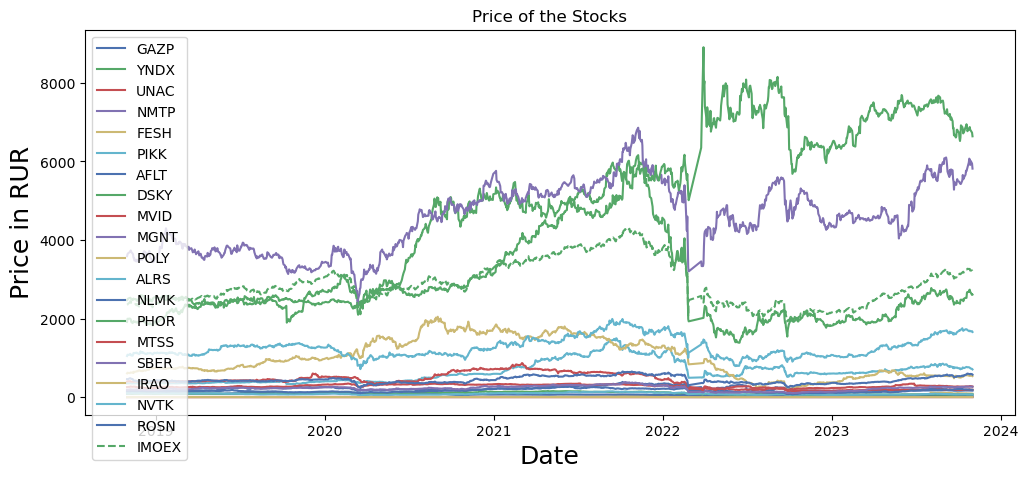

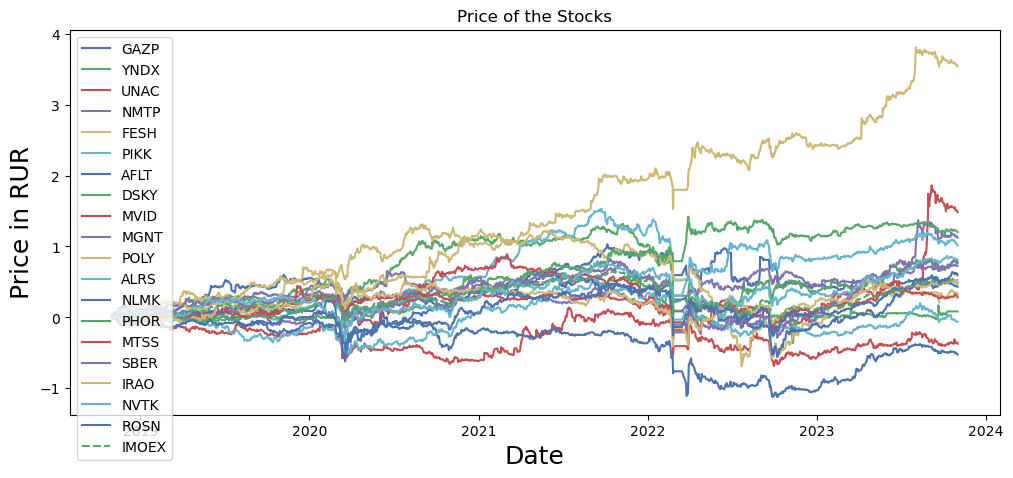

In [15]:
plot_stock_performance(df1=df_assets, df2=df_benchmark)
plot_stock_performance(
    df1=df_assets.pct_change()[1:].cumsum(), 
    df2=df_benchmark.pct_change()[1:].cumsum()
)

In [16]:
# подбор оптимальных весов
df_assets_performance = df_assets.pct_change()[1:]
df_benchmark_performance = df_benchmark.pct_change()[1:]

# считаем cov(r_i, r_m) -- ковариацию доходности каждой акции и индекса
# считаем sigma^2_m -- дисперсию рыночной доходности
# считаем beta для каждой акции


all_betas = check_beta_sustainability(
    df_assets_performance, df_benchmark_performance
).round(decimals=4)


rfr = 11.92 / 100
erp = 0.10
exp_returns = rfr + all_betas.monthly_avg_beta * erp


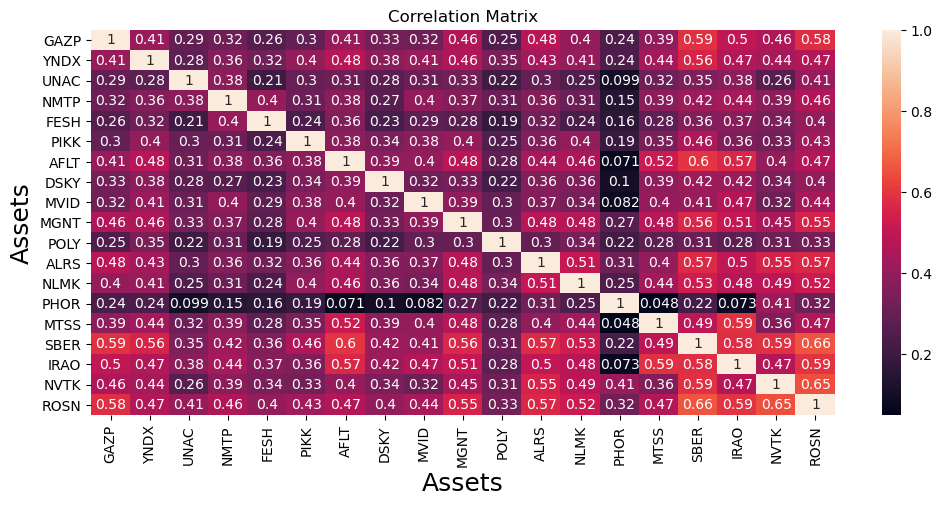

In [17]:
make_corr_mat(df_assets_performance)

In [18]:
assets_cov = df_assets_performance.cov() * 252
ef = EfficientFrontier(exp_returns, assets_cov, weight_bounds=(0,1))
opt_weights = ef.max_sharpe()
cleaned_opt_weights = ef.clean_weights() 

df_assets111 = df_assets.copy(); df_benchmark111 = df_benchmark.copy()
ret = expected_returns.capm_return(
    df_assets111, market_prices = df_benchmark111, compounding=False,
    returns_data=False, risk_free_rate=rfr, frequency=252
)

df_assets112 = df_assets.copy(); df_benchmark112 = df_benchmark.copy()
ret1 = expected_returns.capm_return(
    df_assets112, market_prices = df_benchmark112, compounding=False,
    returns_data=False, risk_free_rate=rfr, frequency=252
)


    

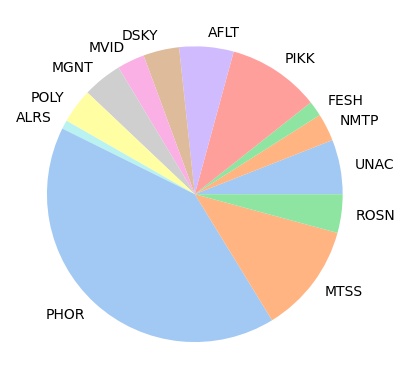

In [25]:
make_pie_graph_weights(cleaned_opt_weights)

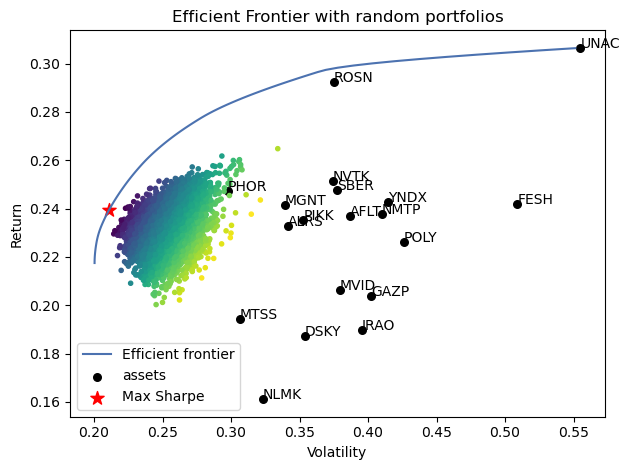

In [20]:
plot_efficient_frontier(
    EfficientFrontier(exp_returns, assets_cov, weight_bounds=(0,1))
)

In [21]:
cleaned_opt_weights

OrderedDict([('GAZP', 0.0),
             ('YNDX', 0.0),
             ('UNAC', 0.0596),
             ('NMTP', 0.03028),
             ('FESH', 0.01669),
             ('PIKK', 0.10102),
             ('AFLT', 0.05943),
             ('DSKY', 0.03926),
             ('MVID', 0.02995),
             ('MGNT', 0.04313),
             ('POLY', 0.03791),
             ('ALRS', 0.00954),
             ('NLMK', 0.0),
             ('PHOR', 0.41071),
             ('MTSS', 0.12033),
             ('SBER', 0.0),
             ('IRAO', 0.0),
             ('NVTK', 0.0),
             ('ROSN', 0.04216)])

# Генерация траекторий цен активов

In [25]:
df_assets = pd.read_csv('assets.txt')
df_assets['Year month'] = df_assets['TRADEDATE'].apply(lambda x: x[:-2])
df_assets
df_assets.set_index('TRADEDATE', drop = True, inplace = True)
df_assets_monthly = df_assets.drop_duplicates(subset='Year month', keep = 'last')
df_assets_monthly

,GAZP,YNDX,UNAC,NMTP,FESH,PIKK,AFLT,DSKY,MVID,MGNT,POLY,ALRS,NLMK,PHOR,MTSS,SBER,IRAO,NVTK,ROSN,Year month
TRADEDATE,,,,,,,,,,,,,,,,,,,,
2018-10-31,155.47,1916.5,0.8090,6.135,4.990,352.3,97.25,89.50,398.5,3590.0,608.0,99.90,160.42,2470.0,257.60,189.80,3.9820,1049.8,460.45,2018-10-
2018-11-30,161.29,1965.0,0.7760,6.830,4.925,351.1,114.40,93.50,418.2,3500.0,667.3,99.63,158.36,2593.0,247.55,194.00,4.0950,1127.2,423.10,2018-11-
2018-12-29,153.50,1930.0,0.7880,6.850,4.710,376.3,101.18,90.44,410.0,3511.5,731.2,98.62,157.42,2546.0,238.00,186.30,3.8795,1132.0,432.50,2018-12-
2019-01-31,162.82,2212.0,0.8070,6.920,5.495,352.0,107.92,90.90,400.6,4155.0,746.9,98.56,152.02,2583.0,260.75,217.90,3.8250,1145.0,411.25,2019-01-
2019-02-28,158.99,2208.0,0.7030,7.450,5.065,359.0,97.10,88.92,412.0,3780.0,778.0,95.10,158.44,2555.0,253.00,207.80,3.9150,1080.4,398.80,2019-02-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,166.86,2439.6,0.7515,9.770,66.250,758.3,42.70,71.26,190.2,5156.0,523.4,70.30,172.74,7310.0,296.75,239.61,4.0370,1335.0,482.35,2023-06-
2023-07-31,174.33,2635.0,0.7780,10.275,88.100,783.9,45.63,70.58,218.3,5797.5,NaN,85.50,211.44,7548.0,290.10,267.40,4.1605,1519.4,508.75,2023-07-
2023-08-31,177.99,2689.0,1.9895,15.100,109.440,827.0,44.02,68.18,196.0,6080.0,NaN,81.27,204.30,7314.0,284.10,264.85,4.1920,1684.8,556.15,2023-08-


In [26]:
def simulate_stock_prices(
        stockData:pd.DataFrame, 
        mc_sims:int, 
        time_periods:int, 
        dt=1.0
        ) -> np.ndarray:
    """
    Arguments
    ----------
    stocksData : pd.DataFrame
        DataFrame with stock Close prices,
    mc_sims : int
        number of trajectories to simulate
    time_periods : int
        number of periods to predict
    dt : flaot
        equals to 1 by default as mean return and covarince matrix is calculated inside the function

    Returns
    -------
    price_predict : np.nparray(mc_sims, stock_number, time_periods)
        a np.ndarray with predicted prices, the 0-th is the last Close price
    """
    global stocks_number, stock_tickers
    returns = stockData.pct_change()
    meanReturns = returns.mean().values
    covMatrix = returns.cov().values
    corrMatrix = returns.corr().values

    stocks_number = covMatrix.shape[0]
    stock_tickers = list(stockData.columns.values)

    prices_predicted = np.zeros(shape=(mc_sims, stocks_number, time_periods+1))
    #generating various trajectories
    for m in tqdm(range(0, mc_sims)):
        Z = np.random.normal(size=(time_periods, stocks_number))
        L = np.linalg.cholesky(corrMatrix)
        Z_corr = np.dot(L, Z.T).T
        for stock_number in range(stocks_number):
            #zero index stands for now(it isn't predicted)
            prices_predicted[m, stock_number, 0] = stockData.iloc[-1, stock_number]
            for time in range(1, time_periods+1):
                prices_predicted[m, stock_number, time] = prices_predicted[m, stock_number, time - 1] * np.exp((meanReturns[stock_number] -  0.8*covMatrix[stock_number, stock_number]) * dt + np.sqrt(covMatrix[stock_number, stock_number]) * Z_corr[time - 1, stock_number] * np.sqrt(dt)
                )
    return prices_predicted

In [27]:
df_assets_monthly.drop('Year month', axis = 1, inplace = True)
df_assets_monthly

,GAZP,YNDX,UNAC,NMTP,FESH,PIKK,AFLT,DSKY,MVID,MGNT,POLY,ALRS,NLMK,PHOR,MTSS,SBER,IRAO,NVTK,ROSN
TRADEDATE,,,,,,,,,,,,,,,,,,,
2018-10-31,155.47,1916.5,0.8090,6.135,4.990,352.3,97.25,89.50,398.5,3590.0,608.0,99.90,160.42,2470.0,257.60,189.80,3.9820,1049.8,460.45
2018-11-30,161.29,1965.0,0.7760,6.830,4.925,351.1,114.40,93.50,418.2,3500.0,667.3,99.63,158.36,2593.0,247.55,194.00,4.0950,1127.2,423.10
2018-12-29,153.50,1930.0,0.7880,6.850,4.710,376.3,101.18,90.44,410.0,3511.5,731.2,98.62,157.42,2546.0,238.00,186.30,3.8795,1132.0,432.50
2019-01-31,162.82,2212.0,0.8070,6.920,5.495,352.0,107.92,90.90,400.6,4155.0,746.9,98.56,152.02,2583.0,260.75,217.90,3.8250,1145.0,411.25
2019-02-28,158.99,2208.0,0.7030,7.450,5.065,359.0,97.10,88.92,412.0,3780.0,778.0,95.10,158.44,2555.0,253.00,207.80,3.9150,1080.4,398.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,166.86,2439.6,0.7515,9.770,66.250,758.3,42.70,71.26,190.2,5156.0,523.4,70.30,172.74,7310.0,296.75,239.61,4.0370,1335.0,482.35
2023-07-31,174.33,2635.0,0.7780,10.275,88.100,783.9,45.63,70.58,218.3,5797.5,NaN,85.50,211.44,7548.0,290.10,267.40,4.1605,1519.4,508.75
2023-08-31,177.99,2689.0,1.9895,15.100,109.440,827.0,44.02,68.18,196.0,6080.0,NaN,81.27,204.30,7314.0,284.10,264.85,4.1920,1684.8,556.15


In [28]:
prices_predicted = simulate_stock_prices(
    stockData=df_assets_monthly,
    mc_sims=5_000,
    time_periods=12*20,
    dt=1.0
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:10<00:00, 26.27it/s]


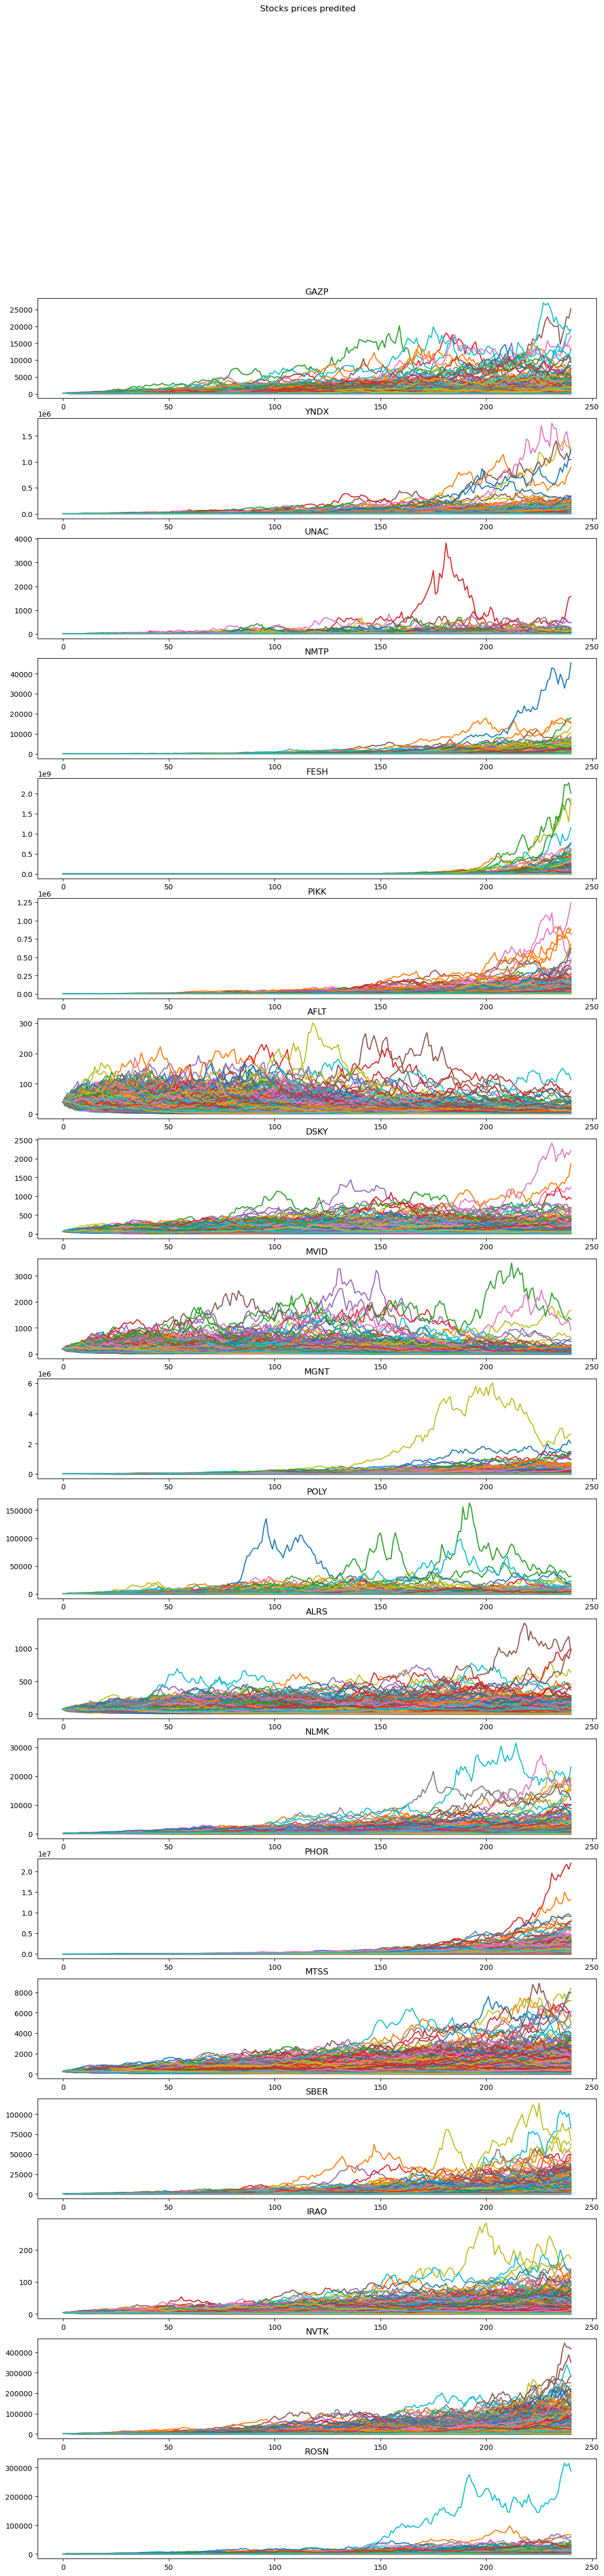

In [61]:
fig, axs = plt.subplots(stocks_number)
fig.set_size_inches(14, stocks_number * 3)
fig.suptitle('Stocks prices predited')
for stock_number in range(stocks_number):
    axs[stock_number].set_title(stock_tickers[stock_number])
    axs[stock_number].plot(prices_predicted[:, stock_number, :].T)

In [30]:
from collections import OrderedDict
cleaned_opt_weights = dict(OrderedDict([('GAZP', 0.0),
             ('YNDX', 0.0),
             ('UNAC', 0.0596),
             ('NMTP', 0.03028),
             ('FESH', 0.01669),
             ('PIKK', 0.10102),
             ('AFLT', 0.05943),
             ('DSKY', 0.03926),
             ('MVID', 0.02995),
             ('MGNT', 0.04313),
             ('POLY', 0.03791),
             ('ALRS', 0.00954),
             ('NLMK', 0.0),
             ('PHOR', 0.41071),
             ('MTSS', 0.12033),
             ('SBER', 0.0),
             ('IRAO', 0.0),
             ('NVTK', 0.0),
             ('ROSN', 0.04216)]))

# Вычисление распределения доходностей нашего портфеля

In [31]:
def static_rebalance(current_assets: list,
                     current_prices: list,
                     proportions: list,
                     cash_flow: float) -> list:
    
    """This function takes lists of current assets (number of each), 
    their current prices, needed proportions of values (estimated through theory),
    and cash flow (deposit or withdraw).
    It rerurns the list of rebalanced numbers of each asset"""
    
    # len of all lists should be the same
    if (len(current_assets) != len(current_prices)) or (len(current_assets) != len(proportions)):
        raise ValueError('All lists should have same size')
    
    # calculating total value of our current shares
    total_value = 0
    for i in range(len(current_assets)):
        total_value += current_assets[i] * current_prices[i]
    
    # add deposit/withdraw
    total_value += cash_flow
    if total_value < 0:
        raise ValueError('Too big withdraw')
    
    # calculating new numbers
    rebalanced_assets = []
    for i in range(len(proportions)):
        rebalanced_assets.append(total_value * proportions[i] / current_prices[i])
        
    return rebalanced_assets

def total_value_func(current_assets: list, current_prices: list) -> float:
    total_value = 0
    for i in range(len(current_assets)):
        total_value += current_assets[i] * current_prices[i]
    return total_value

In [32]:
df_assets_monthly

,GAZP,YNDX,UNAC,NMTP,FESH,PIKK,AFLT,DSKY,MVID,MGNT,POLY,ALRS,NLMK,PHOR,MTSS,SBER,IRAO,NVTK,ROSN
TRADEDATE,,,,,,,,,,,,,,,,,,,
2018-10-31,155.47,1916.5,0.8090,6.135,4.990,352.3,97.25,89.50,398.5,3590.0,608.0,99.90,160.42,2470.0,257.60,189.80,3.9820,1049.8,460.45
2018-11-30,161.29,1965.0,0.7760,6.830,4.925,351.1,114.40,93.50,418.2,3500.0,667.3,99.63,158.36,2593.0,247.55,194.00,4.0950,1127.2,423.10
2018-12-29,153.50,1930.0,0.7880,6.850,4.710,376.3,101.18,90.44,410.0,3511.5,731.2,98.62,157.42,2546.0,238.00,186.30,3.8795,1132.0,432.50
2019-01-31,162.82,2212.0,0.8070,6.920,5.495,352.0,107.92,90.90,400.6,4155.0,746.9,98.56,152.02,2583.0,260.75,217.90,3.8250,1145.0,411.25
2019-02-28,158.99,2208.0,0.7030,7.450,5.065,359.0,97.10,88.92,412.0,3780.0,778.0,95.10,158.44,2555.0,253.00,207.80,3.9150,1080.4,398.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,166.86,2439.6,0.7515,9.770,66.250,758.3,42.70,71.26,190.2,5156.0,523.4,70.30,172.74,7310.0,296.75,239.61,4.0370,1335.0,482.35
2023-07-31,174.33,2635.0,0.7780,10.275,88.100,783.9,45.63,70.58,218.3,5797.5,NaN,85.50,211.44,7548.0,290.10,267.40,4.1605,1519.4,508.75
2023-08-31,177.99,2689.0,1.9895,15.100,109.440,827.0,44.02,68.18,196.0,6080.0,NaN,81.27,204.30,7314.0,284.10,264.85,4.1920,1684.8,556.15


In [33]:
start_assets = {}
needed_proportions = []
for one_ticker in stock_tickers:
    start_assets[one_ticker] = 0
    needed_proportions.append(cleaned_opt_weights[one_ticker])
    
# потом будет импортировать эти числа из икселя
cash_list = pd.read_csv('nominal_cashflows.csv')['cashflow'].to_list()

In [34]:
if len(prices_predicted[0][0]) != len(cash_list):
    raise ValueError("Cash flow and Asset price vectors should have same size") 

monthly_values = []
final_values = []
    
for one_traj in tqdm(range(len(prices_predicted))):
    one_traj_monthly = []
    assets_amounts = list(start_assets.values())
    assets_tickers = list(start_assets.keys())
    for one_date in range(len(cash_list)):

        #get cashflow for this date
        cashflow = cash_list[one_date]

        #get current assets prices
        c_prices = []
        for one_asset in range(len(assets_tickers)):
            
            one_price = prices_predicted[one_traj][one_asset][one_date]
            c_prices.append(one_price)

        assets_amounts = static_rebalance(assets_amounts, c_prices, needed_proportions, cashflow)
        total_value = total_value_func(assets_amounts, c_prices)
        
        one_traj_monthly.append(total_value)
        
    monthly_values.append(one_traj_monthly)
    final_values.append(total_value)
        

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:42<00:00, 117.03it/s]


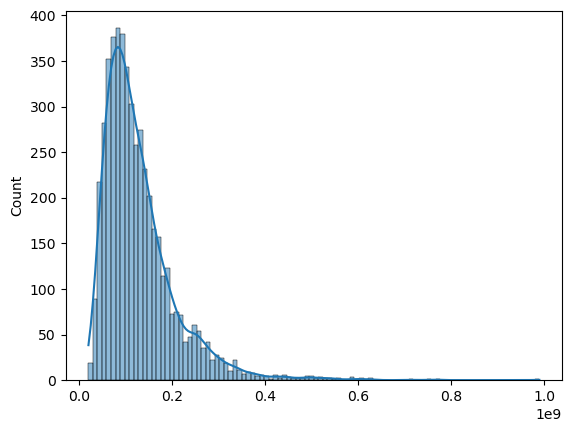

In [35]:
sns.histplot(final_values, kde=True, bins = 100);

In [36]:
result_values = pd.DataFrame()
result_values['result_value'] = final_values
result_values.describe()

,result_value
count,5.000000e+03
mean,1.281430e+08
std,7.911273e+07
min,1.929219e+07
25%,7.539484e+07
50%,1.081410e+08
75%,1.573022e+08
max,9.892624e+08


In [37]:
108.14/(1.04**20)

49.35368436220774

## Risk free

In [38]:
riskfree_price = [1]
# one_m = ((1 + 11.92 / 100)**20 - 1) / 240
one_m = ((1 +  11.92/ 100)**20 - 1) / 240
for i in range(240):
    riskfree_price.append(riskfree_price[-1] + one_m)

In [39]:
cash_list = pd.read_csv('nominal_cashflows.csv')['cashflow'].to_list()

In [40]:
# когда инвестируем все в риск-фри
needed_proportions = [1]
assets_amounts = [0]
one_traj_monthly = []
for one_date in range(len(riskfree_price)):

    #get cashflow for this date
    cashflow = cash_list[one_date]

    #get current assets prices
    c_prices = [riskfree_price[one_date]]

    assets_amounts = static_rebalance(assets_amounts, c_prices, needed_proportions, cashflow)
    total_value = total_value_func(assets_amounts, c_prices)

    one_traj_monthly.append(total_value)
    

In [41]:
one_traj_monthly[-1]

67506864.37554234